In [1]:
from ASGCNN.Encoder import Graph_data_loader, Encoder_element
from ASGCNN.Model import ASGCNN
from ASGCNN.Trainer import Trainer, setup_seed, node_feature_forward_selection, show_forawrd_selection

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

Here we introduce some training methods such as adjusting hyperparameters and ensemble models.  

# hyperparameter tuning
We using [**hyperopt**](http://hyperopt.github.io/hyperopt/) (see also [Chinese interpretation](https://cloud.tencent.com/developer/article/2009339)) to tune hyperparameters, an example is as follow.

In [2]:
# define load data function, reload every time to make sure the data is the same for each batch after random shuffling
def load_data():
    target = ['Cadsb', 'Csite', 'Gads']

    Loader_train = Graph_data_loader(256)
    Loader_train.load_data(
        data_excel='data/Train_data_5000.csv', 
        encoders=['data/Graph_adsb_train.bin', 'data/Graph_slab_train.bin'], 
        target=target)

    Loader_valid = Graph_data_loader(500)
    Loader_valid.load_data(
        data_excel='data/Valid_data_500.csv', 
        encoders=['data/Graph_adsb_valid.bin', 'data/Graph_slab_valid.bin'], 
        target=target)
    
    return Loader_train, Loader_valid

# define search space
search_params={
   'conv_num': hp.choice('conv_num',[1,2,3,4,5]),
   'batch_sz': hp.choice('batch_sz',[64, 128, 256, 512]),
   'adsb_eml': hp.quniform('adsb_eml',30,101,10),
   'slab_eml': hp.quniform('slab_eml',30,101,10),
   'fcly_1em': hp.quniform('fcly_1em',30,101,10),
   'fcly_2em': hp.quniform('fcly_2em',10,61,10),
   'fcly_3em': hp.quniform('fcly_3em',10,61,10),
   'loss_w': hp.uniform('loss_w',0.001,1),
}

# define objective function
def run_opt_in_para_set(params):
    setup_seed(123456) # fix seed for repeatable and comparable results
    
    Loader_train, Loader_valid = load_data()
    Loader_train.batch_size=params['batch_sz']
    # define the model
    fcl = [int(params['fcly_1em']),int(params['fcly_2em']),int(params['fcly_3em'])]
    model = ASGCNN(101,6,int(params['adsb_eml']),101,8,int(params['slab_eml']),
                conv_num_adsb=params['conv_num'],fcl_dims=fcl,task_typ='multy',class_dim=[5, 4], regre_dim=[1])
    # deinfe the trainer
    t=Trainer(model, Loader_train, Loader_valid, init_lr=0.1, metric='hyb', scheduler_para=200,
              metric_para={'weight': [params['loss_w'], params['loss_w'], 1 - params['loss_w']]}, target_dims=[5, 4, 1])
    
    t.train(10, disable_tqdm=True) # Increase epoch in a real task
   
    return t.calculate_static()['valid']['mae_2']

# define search process
def param_hyperopt(max_evals=66):
    trials=Trials()
   
    early_stop=no_progress_loss(100)
   
    params_best= fmin(run_opt_in_para_set,
                   space=search_params,
                   algo=tpe.suggest,
                   max_evals=max_evals,
                   verbose=True,
                   trials=trials,
                   early_stop_fn=early_stop)
    return params_best, trials

In [3]:
# Executive hyperparameter search
# Increase the number of searches when actually searching, here only as a demonstration search 3 times

param_hyperopt(3)

# params_best, trials = param_hyperopt(xx)

100%|██████████████████████████████████████████████████| 3/3 [01:23<00:00, 27.77s/trial, best loss: 0.3834953010082245]


({'adsb_eml': 70.0,
  'batch_sz': 2,
  'conv_num': 3,
  'fcly_1em': 50.0,
  'fcly_2em': 60.0,
  'fcly_3em': 40.0,
  'loss_w': 0.6362785763297543,
  'slab_eml': 60.0},
 <hyperopt.base.Trials at 0x1947f567940>)

# Ensemble model
To use the [**snapshot ensemble**](https://arxiv.org/abs/1704.00109) (see also [Chinese interpretation](https://zhuanlan.zhihu.com/p/461565837)), using **.init_snapshot_ensembling**, this will change the **scheduler** on **Trainer** to **cos**, and stored ensemble models during training process.  

Define the ASGCNN model at first:

In [3]:
Loader_train, Loader_valid = load_data()

model = ASGCNN(node_feat_length_adsb=101, edge_feat_length_adsb=6, embed_feat_length_adsb=20, 
               node_feat_length_slab=101, edge_feat_length_slab=8, embed_feat_length_slab=20,
               task_typ='multy', fcl_dims=[40, 20, 5], class_dim=[5, 4], regre_dim=[1])

t = Trainer(Module=model, Dataloader_train=Loader_train, Dataloader_valid=Loader_valid,
    init_lr=0.1, metric='hyb', metric_para={'weight': [0.1, 0.1, 0.9]}, scheduler_para=200, target_dims=[5, 4, 1])

Define the number of models in the ensemble and after how many epochs a snapshot model is stored. Here, we use a **3-model** ensemble, with each model trained for **100 epochs**, resulting in a total training epoch count of **300**.   

You can also initialize the model parameters each time you get the model by setting **weight_init** to True, which is equivalent to a typical ensemble model after multiple training processes on the same data set.

In [4]:
t.init_snapshot_ensembling(cycle_time=3, epoch_each=100, weight_init=False)

In [5]:
t.train(300)

Train epoch:   0%|          | 0/300 [00:00<?, ?e/s]

Now, let's check out the learning rate changing trend during the training process by **show_lr**. You will find that the learning rate goes down to near zero every 200 epochs, and then returns to the initial learning rate. This process is repeated 3 times, and every time the learning rate approaches zero, a snapshot model is stored.

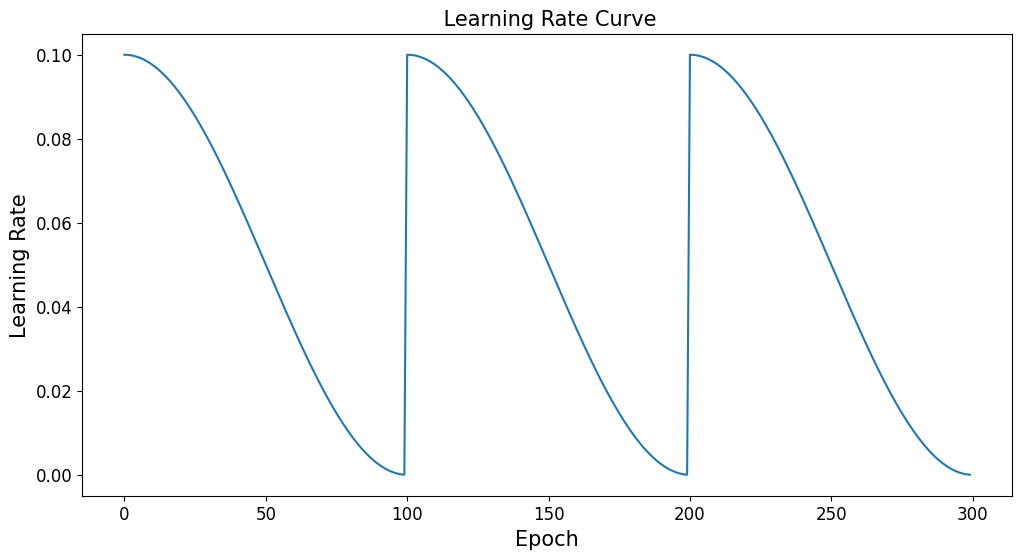

In [6]:
t.show_lr()

Now the prediction is the average prediction values of 5 models, and the standard deviation of these values can be used to measure uncertainty. Using **return_uq** to get uncertainty.

In [7]:
yp, uq = t.predict(Loader_valid, return_uq=True, to_class=True)

In [8]:
yp[:5]

array([[ 2.        ,  3.        , -0.94865704],
       [ 3.        ,  3.        , -0.42403531],
       [ 0.        ,  3.        , -1.74356222],
       [ 3.        ,  3.        ,  0.57823825],
       [ 2.        ,  3.        , -1.190835  ]])

**uq** contains the uncertainty of the predicted value of the regression task

In [9]:
uq[:5]

array([[0.07237463],
       [0.04825438],
       [0.26684266],
       [0.08137615],
       [0.06724206]], dtype=float32)

For classification tasks, the model outputs the probability that each sample belongs to each class, and the confidence of the predicted value can be obtained based on the probability that it belongs to that class.  

For sample 1, it has a probability of 99% to be category 2. But for sample 3, it is only 73% probability to be category 0.

In [10]:
yp = t.predict(Loader_valid, to_class=False)
yp[:5, :5]

array([[1.12677554e-07, 1.37083780e-05, 9.99983013e-01, 4.58082496e-08,
        3.10618088e-06],
       [2.44861003e-04, 1.06112532e-08, 8.72323290e-05, 9.99464214e-01,
        2.03674674e-04],
       [7.27166474e-01, 1.20863326e-01, 1.51778057e-01, 5.74519072e-05,
        1.34666756e-04],
       [4.63912002e-04, 3.18539861e-10, 5.42070120e-06, 9.99205887e-01,
        3.24807683e-04],
       [1.76310337e-07, 3.67493317e-06, 9.99989510e-01, 1.15310861e-07,
        6.54281075e-06]], dtype=float32)

**show_uq** is used to view the true value of the sample, the predicted value, and their uncertainty, which requires you to specify the dataset, the target index, and the start and end indexes of the sample to be displayed. Here we show samples 0 to 30 from the validation set.

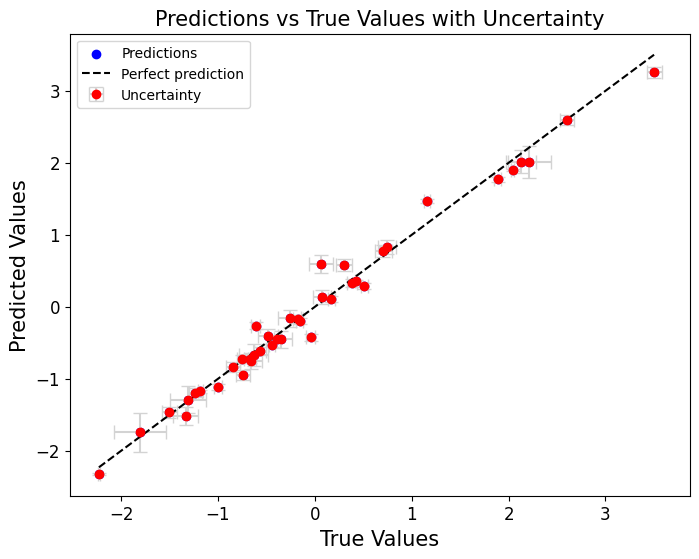

In [12]:
t.show_uq(tir=0, i_s=0, i_e=40, dataset='valid')

# Label distribution smoothing
We also implemented the [**Label distribution smoothing**](https://arxiv.org/abs/2102.09554) (see also [Chinese interpretation](https://zhuanlan.zhihu.com/p/369627086)) for regression task. This will calculate a weight according to the target value distribution. The target values are divided into **different bins**, and the **probability distribution** is approximated by a **kernel function**. Data points with low probability of target quantity distribution will have more weight. This make they have a greater impact on turing network parameters during training process.  

To use this method, run **.get_effective_label_density** at **Graph_data_loader** once you have loaded you training data.  And bring them into training by selecting **wmae** or **hyb** loss functions at **Trainer**.  

For further clarification, refer to:

In [ ]:
help(Loader_train_bulk.get_effective_label_density)

Try to calculate the **effective label density** and **weight** on Loader_train

In [13]:
Loader_train.get_effective_label_density()

You can use **show_effective_label_density** and **show_weight** to see check the data distribution. Let's look at the adsorption energy distribution and the corresponding weights.  

When training multi-target regression tasks, the program calculates a set of weights for each regression task. Although this will compute weights for classification tasks, those weight information is not used in the training process

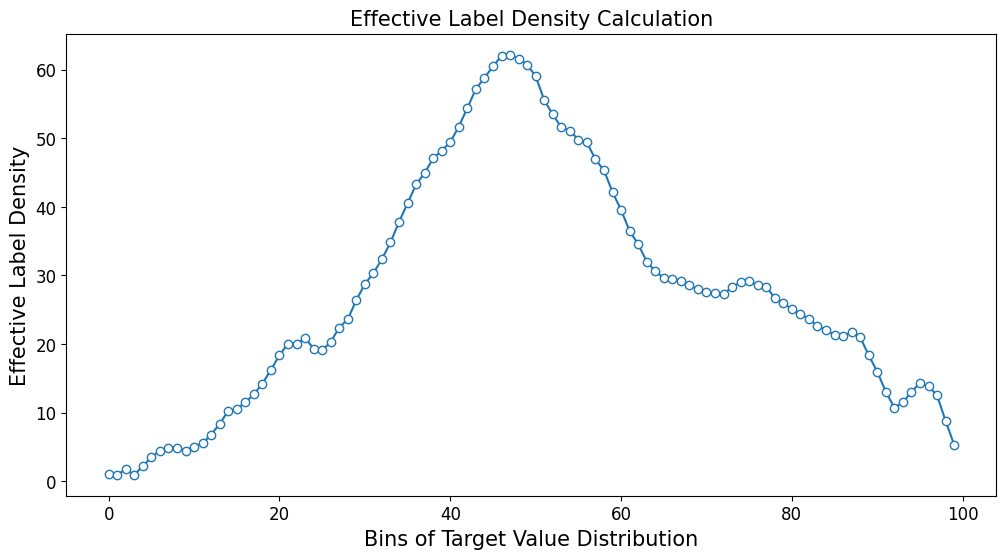

In [14]:
Loader_train.show_effective_label_density(ti=2)

You can see that most of the data is not on the right. The formation energy here is all negative, that is, most of the alloy formation energy is only a little less than 0, and only a few of the alloy formation energy values are very negative. This small portion will get a larger weight, and those have formation energy closed to zero will get a smaller weight.

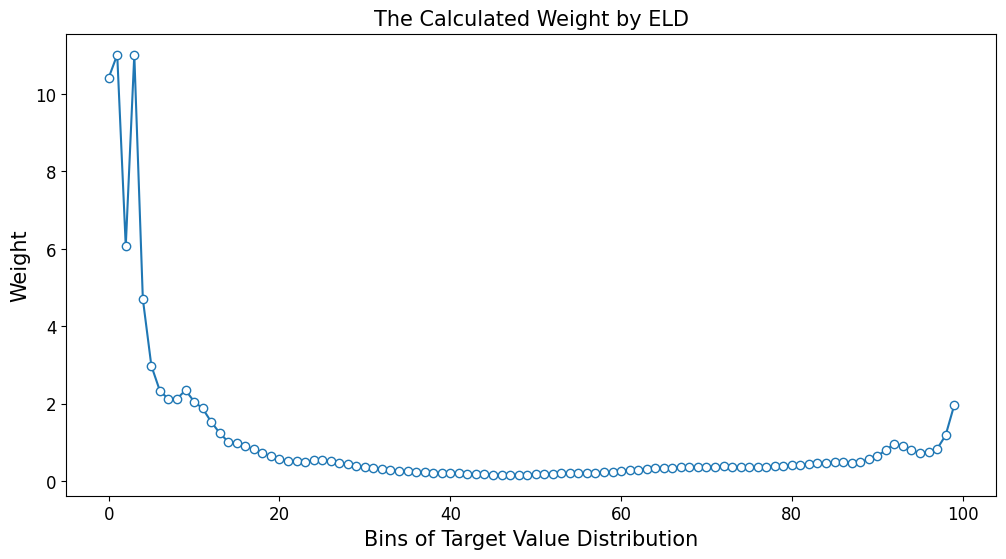

In [15]:
Loader_train.show_weights(ti=2)

# Forward selectoin
Feature forward selection is a method used in statistical analysis and machine learning to select a subset of relevant features for use in model construction. It starts with an empty set of features and iteratively adds the feature that most improves the model's performance until a stopping criterion is met, such as a maximum number of features or a desired level of model accuracy. This approach helps to reduce overfitting and enhance model interpretability by focusing on the most informative features.  

Load dataset, define model and trainer as usual:

In [30]:
Loader_train, Loader_valid = load_data()

model = ASGCNN(node_feat_length_adsb=101, edge_feat_length_adsb=6, embed_feat_length_adsb=20, 
               node_feat_length_slab=101, edge_feat_length_slab=8, embed_feat_length_slab=20,
               task_typ='multy', fcl_dims=[40, 20, 5], class_dim=[5, 4], regre_dim=[1])

t = Trainer(Module=model, Dataloader_train=Loader_train, Dataloader_valid=Loader_valid,
    init_lr=0.1, metric='hyb', metric_para={'weight': [0.1, 0.1, 0.9]}, scheduler_para=200, target_dims=[5, 4, 1])

Using **node_feature_forward_selection** to perfrom forward_selection. Pass in the model class, a well defined **Trainer**, and an **Encoder_element** that defines all the features you want to search for  

To contain more than one graph types of training, currently only supports use same node features for those two graphs.

In [38]:
En = Encoder_element()
features, scores = node_feature_forward_selection(
    model=ASGCNN, 
    trainer=t, 
    element_encoder=En, 
    train_epoch=3, # Increase the number of epoch for real task applications 
    target_metric=[['valid', 'mae_2']])

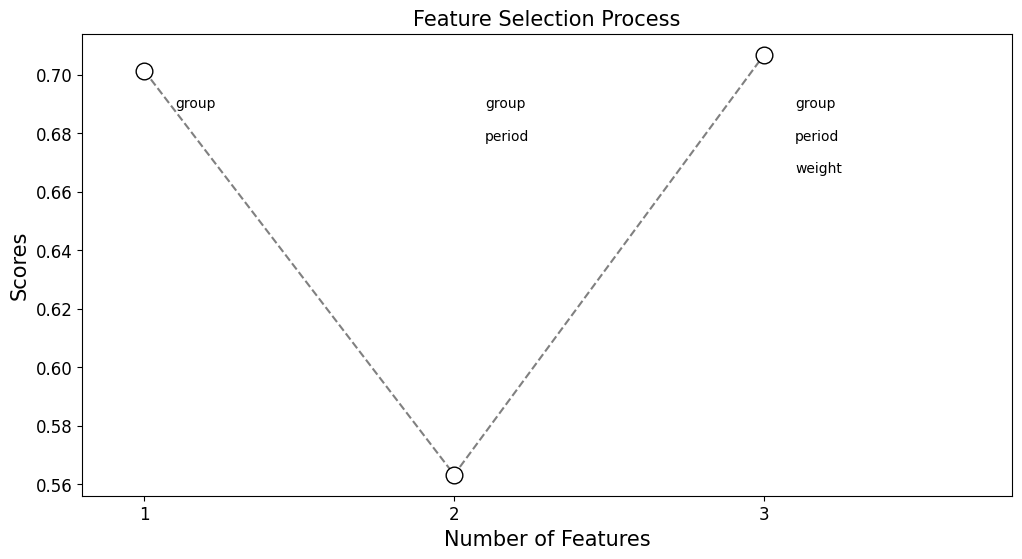

In [39]:
show_forawrd_selection(features, scores)